# Preprocess for training

In [55]:
import os

import numpy as np
import pandas as pd
from pandarallel import pandarallel
import cudf
import matplotlib.pyplot as plt

import gc
import torch

In [56]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

In [57]:
class CFG:
    is_debug = False
    input_dir = os.path.join("/kaggle", "input")
    output_dir = os.path.join("/kaggle", "working")
    competition_dir = os.path.join(input_dir, "child-mind-institute-detect-sleep-states")
    train_series = os.path.join(competition_dir, "train_series.parquet")
    train_event = os.path.join(competition_dir, "train_events.csv")

    train_series_non_null = os.path.join(input_dir, "processed_train_withkey_nonull.parquet")

    test_series = os.path.join(competition_dir, "test_series.parquet")
    sample_sub = os.path.join(competition_dir, "sample_submission.csv")

In [58]:
train_series = pd.read_parquet(CFG.train_series_non_null)

In [59]:
train_series

,series_id,series_date_key,timestamp,date,time,step,anglez,enmo,event,event_onset,event_wakeup
0,08db4255286f,08db4255286f_2018-11-05,2018-11-05 10:00:00,2018-11-05,10:00:00,0,-30.845301,0.0447,0.0,0,0
1,08db4255286f,08db4255286f_2018-11-05,2018-11-05 10:00:05,2018-11-05,10:00:05,1,-34.181801,0.0443,0.0,0,0
2,08db4255286f,08db4255286f_2018-11-05,2018-11-05 10:00:10,2018-11-05,10:00:10,2,-33.877102,0.0483,0.0,0,0
3,08db4255286f,08db4255286f_2018-11-05,2018-11-05 10:00:15,2018-11-05,10:00:15,3,-34.282101,0.0680,0.0,0,0
4,08db4255286f,08db4255286f_2018-11-05,2018-11-05 10:00:20,2018-11-05,10:00:20,4,-34.385799,0.0768,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14329112,d5e47b94477e,d5e47b94477e_2017-12-02,2017-12-02 07:47:40,2017-12-02,07:47:40,390092,23.911301,0.0000,1.0,0,0
14329113,d5e47b94477e,d5e47b94477e_2017-12-02,2017-12-02 07:47:45,2017-12-02,07:47:45,390093,23.911301,0.0000,1.0,0,0
14329114,d5e47b94477e,d5e47b94477e_2017-12-02,2017-12-02 07:47:50,2017-12-02,07:47:50,390094,23.880699,0.0000,1.0,0,0
14329115,d5e47b94477e,d5e47b94477e_2017-12-02,2017-12-02 07:47:55,2017-12-02,07:47:55,390095,23.940100,0.0000,1.0,0,0


In [60]:
# key_col = "series_date_key"
# for idx, series in enumerate(train_series["series_date_key"].unique()):
#     print(series)
#     plt.figure(figsize=(20, 5))
#     plt.subplot(5, 1, 1)
#     plt.plot(train_series[train_series[key_col] == series]["step"], train_series[train_series[key_col] == series]["anglez"])
#     plt.subplot(5, 1, 2)
#     plt.plot(train_series[train_series[key_col] == series]["step"], train_series[train_series[key_col] == series]["enmo"])
#     plt.subplot(5, 1, 3)
#     plt.plot(train_series[train_series[key_col] == series]["step"], train_series[train_series[key_col] == series]["event"])
#     plt.subplot(5, 1, 4)
#     plt.plot(train_series[train_series[key_col] == series]["step"], train_series[train_series[key_col] == series]["event_onset"])
#     plt.subplot(5, 1, 5)
#     plt.plot(train_series[train_series[key_col] == series]["step"], train_series[train_series[key_col] == series]["event_wakeup"])
#     plt.show()
#     if idx == 3:
#         break

In [61]:
import torch
import torch.nn as nn


kernel_size = 11
stride = 1
# 入力サイズと出力サイズが一致するようにpaddingを調整
padding = int((kernel_size - stride) / 2)
print(padding)
max_pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
ave_kernel_size = 111
ave_stride = 1
ave_padding = int((ave_kernel_size - ave_stride) / 2)
average_pool = nn.AvgPool1d(kernel_size=ave_kernel_size, stride=ave_stride, padding=ave_padding)


input = torch.randn(1, 1, 100)
max_pooled = max_pool(input)
print(max_pooled.shape)

average_pooled = average_pool(input)
print(average_pooled.shape)

5
torch.Size([1, 1, 100])
torch.Size([1, 1, 100])


08db4255286f_2018-11-06


/tmp/ipykernel_7598/1857099572.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_onset = max_pool(torch.tensor(event_onset,dtype=torch.float32))
/tmp/ipykernel_7598/1857099572.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  event_wakeup = max_pool(torch.tensor(event_wakeup,dtype=torch.float32))


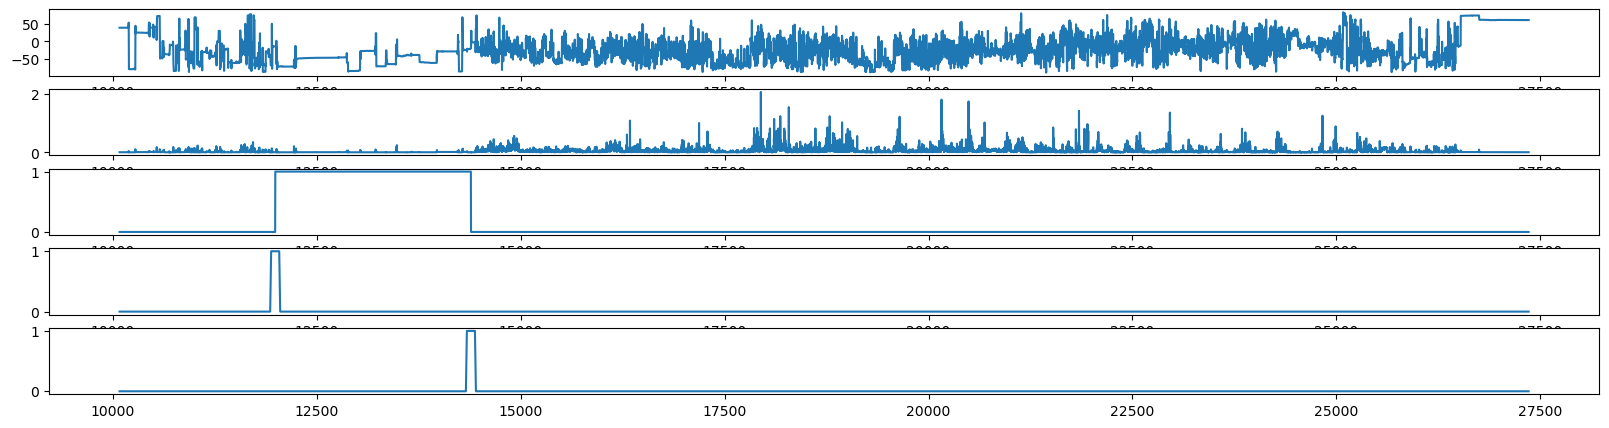

08db4255286f_2018-11-07


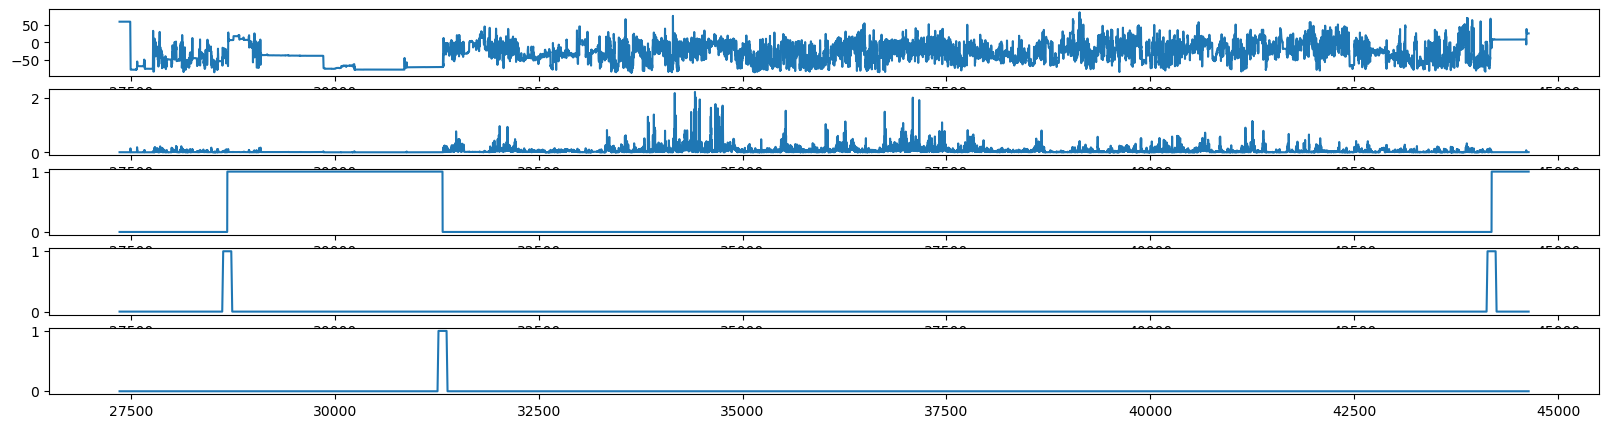

In [65]:
key_col = "series_date_key"
for idx, series in enumerate(train_series["series_date_key"].unique()):
    if idx < 1:
        continue
    elif idx == 3:
        break
    print(series)
    plt.figure(figsize=(20, 5))
    plt.subplot(5, 1, 1)
    plt.plot(train_series[train_series[key_col] == series]["step"], train_series[train_series[key_col] == series]["anglez"])
    plt.subplot(5, 1, 2)
    plt.plot(train_series[train_series[key_col] == series]["step"], train_series[train_series[key_col] == series]["enmo"])
    plt.subplot(5, 1, 3)
    plt.plot(train_series[train_series[key_col] == series]["step"], train_series[train_series[key_col] == series]["event"])
    plt.subplot(5, 1, 4)
    event_onset = train_series[train_series[key_col] == series]["event_onset"].values
    event_onset = torch.from_numpy(event_onset).unsqueeze(0)
    event_onset = max_pool(torch.tensor(event_onset,dtype=torch.float32))
    event_onset = average_pool(event_onset).squeeze(0).numpy()
    # 0~1に正規化
    event_onset = event_onset / event_onset.max()
    plt.plot(train_series[train_series[key_col] == series]["step"], event_onset)
    plt.subplot(5, 1, 5)
    event_wakeup = train_series[train_series[key_col] == series]["event_wakeup"].values
    event_wakeup = torch.from_numpy(event_wakeup).unsqueeze(0)
    event_wakeup = max_pool(torch.tensor(event_wakeup,dtype=torch.float32))
    event_wakeup = average_pool(event_wakeup).squeeze(0).numpy()
    event_wakeup = event_wakeup / event_wakeup.max()
    plt.plot(train_series[train_series[key_col] == series]["step"], event_wakeup)
    plt.show()
